#### 1. Data Preparation


In [10]:
import glob
import os

def findfiles(path): return glob.glob(path)  #finds file matching a specific pattern with file directory
print(findfiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,:'"
n_letters = len(all_letters)

#turn unicode string into plain ASCII
def unicodeToascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )



['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [11]:
print(unicodeToascii('Ślusàrski'))

Slusarski


In [12]:
# dict - list of names per language
category_lines = {}
all_categories = []

# read a file and split into lines
def readlines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToascii(line) for line in lines]

for filename in findfiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readlines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


#### 2. Turning names into tensors

In [14]:
import torch 

# find letter index from all_letters, eg. 'a'=0
def letterToindex(letter):
    return all_letters.find(letter)

#turning a letter into a <1 x n_letters> tensor
def letterTotensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToindex(letter)] = 1
    return tensor

# turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineTotensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToindex(letter)] = 1
    return tensor

print(letterTotensor('j'))

print(lineTotensor('jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#### 3. Model creation

In [15]:
import torch.nn as nn
import torch.nn.functional as F # offers utility functions

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)  # linear - perform matrix multiplication + adds bias
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) #normalize 'h2o layer' into probability distrib. for classification

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    # initialize hidden state with 0's
    def initHidden(self):   
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

to run a setup of this network we need to pass an input (in our case, the tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). we'll get back the output (probability of each language) and a next hidden state (which we keep for the next step)

In [16]:
input = letterTotensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)  # passes two args for forward func on an object of RNN class

for the sake of efficiency we dont want to be creating a new tensor for every step, so we will use LineTotensor and use slices. this could be further optimized by precomputing batches of tensor

In [17]:
input = lineTotensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0631, -2.8540, -2.9247, -2.9081, -2.9186, -2.8319, -2.8456, -2.8984,
         -2.7965, -2.9242, -2.8708, -2.9396, -2.7940, -2.9173, -2.9545, -2.8165,
         -2.8774, -2.9277]], grad_fn=<LogSoftmaxBackward0>)


#### 4. Training

In [18]:
def categoryfromoutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryfromoutput(output))

('Polish', 12)


In [19]:
# training example
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineTotensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line=', line)

category = Irish / line= Rodagh
category = French / line= Deschamps
category = Czech / line= Simecek
category = Vietnamese / line= Quach
category = English / line= Norgrove
category = Arabic / line= Fakhoury
category = Polish / line= Krol
category = Scottish / line= Hay
category = Scottish / line= Milne
category = Greek / line= Georgeakopoulos


#### 5. Network Training

In [20]:
criterion = nn.NLLLoss()

In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryfromoutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 0.4917 Nataga / Japanese ✓


10000 10% (0m 31s) 0.8833 Nghiem / Vietnamese ✓
15000 15% (0m 48s) 2.8364 Diaz / Vietnamese ✗ (Spanish)
20000 20% (1m 5s) 0.1079 Miyahara / Japanese ✓
25000 25% (1m 21s) 0.7286 Nguyen / Vietnamese ✓
30000 30% (1m 38s) 1.1973 Royer / French ✓
35000 35% (1m 55s) 6.9848 Register / German ✗ (Irish)
40000 40% (2m 12s) 0.2042 Barros / Portuguese ✓
45000 45% (2m 28s) 2.2101 Kattan / Dutch ✗ (Arabic)
50000 50% (2m 44s) 0.1870 Douglas / Scottish ✓
55000 55% (3m 0s) 0.6061 Babadzhan / Russian ✓
60000 60% (3m 15s) 4.2695 Ventura / Spanish ✗ (English)
65000 65% (3m 33s) 0.3494 Zinnurov / Russian ✓
70000 70% (3m 49s) 2.1241 Blanxart / French ✗ (Spanish)
75000 75% (4m 6s) 0.1522 Lieu / Vietnamese ✓
80000 80% (4m 24s) 0.2329 Kijek / Polish ✓
85000 85% (4m 42s) 0.3873 Shamon / Arabic ✓
90000 90% (4m 58s) 0.0005 Antonakos / Greek ✓
95000 95% (5m 14s) 0.1516 Samaha / Arabic ✓
100000 100% (5m 30s) 0.2190 Dufour / French ✓


#### 6. plotting the results

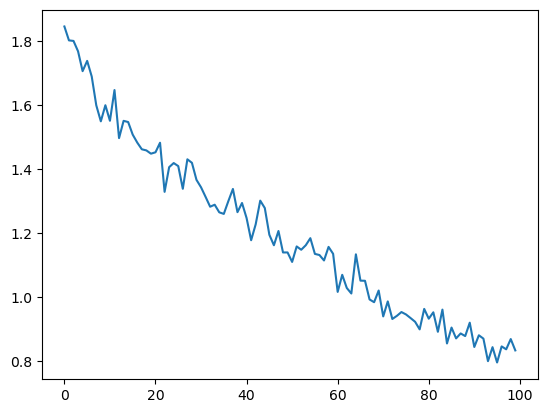

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 7. Result Evaluation

C:\Users\osama\AppData\Local\Temp\ipykernel_1360\785218434.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\osama\AppData\Local\Temp\ipykernel_1360\785218434.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


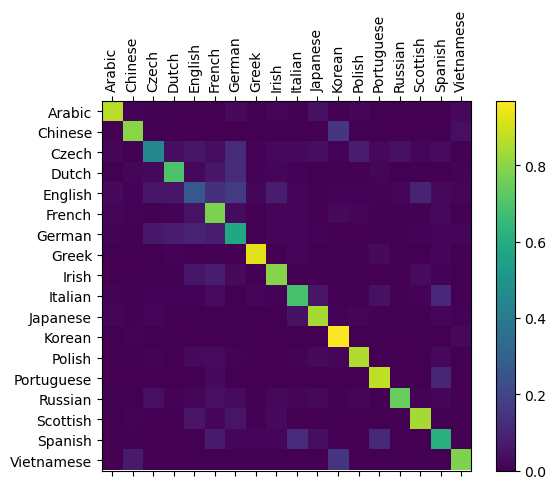

In [28]:
# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# return output when given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output  

# run some examples and record the ones correctly guessed
for i in range(n_confusion):
    category, line, categroy_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryfromoutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# normalize by dividing every row by its sum 
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

#setup axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

#force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# shinx_gallery_thumbnail_number = 2
plt.show()

#### 8. running on user input

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineTotensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.45) Russian
(-1.92) English
(-2.18) French

> Jackson
(-0.15) Scottish
(-2.11) English
(-5.20) French

> Satoshi
(-0.69) Japanese
(-0.89) Arabic
(-2.77) Italian
